# ETF - Strategy Backtesting

### Strategy:
1. At the start of each week, check the 30 week (6 months) rate of change of NiftyBees and GoldBees.
2. If none of the ETFs are returning more than 3% in 6 months. Do nothing. Be invested in LiquidBees.
3. If one or both ETFs are returning more than 3% invest your entire position in that ETF. (Higher Performance ETF).

Backtested results excluding dividends 2005-2015
* 10 Years
* CAGR: 25.22%
* Max Drawdown: 21.96%

(^ backtest results as given)

In [1]:
import pandas as pd
import quandl

In [2]:
quandl_key = open("data/quandlkey").readline().rstrip()
quandl.ApiConfig.api_key = quandl_key

In [3]:
df = quandl.get(["NSE/NIFTYBEES.5",
                 "NSE/GOLDBEES.5",
                 "NSE/LIQUIDBEES.5"]).rename(columns={'NSE/NIFTYBEES - Close': 'nc',
                                                      'NSE/GOLDBEES - Close': 'gc',
                                                      'NSE/LIQUIDBEES - Close': 'lc'})

In [4]:
df = df.dropna()
df['wn'] = df.index.weekofyear
print(df)

                 nc       gc       lc  wn
Date                                     
2007-03-19   369.79   947.80   999.99  12
2007-03-20   372.52   942.39   999.99  12
2007-03-21   379.69   945.67   999.99  12
2007-03-22   390.03   950.15  1000.00  12
2007-03-23   390.19   947.18   999.99  12
2007-03-26   386.76   940.71   999.99  13
2007-03-28   377.86   943.65  1000.00  13
2007-03-29   381.67   946.90   999.99  13
2007-03-30   384.04   947.05   999.99  13
2007-04-02   369.51   944.82  1000.00  14
2007-04-03   371.67   940.38  1000.01  14
2007-04-04   374.37   939.62  1000.00  14
2007-04-05   378.36   946.37  1000.00  14
2007-04-09   386.61   945.83  1000.00  15
2007-04-10   386.29   948.79   999.99  15
2007-04-11   387.55   948.89  1000.00  15
2007-04-12   386.68   948.18  1000.00  15
2007-04-13   392.69   948.41   999.99  15
2007-04-16   402.93   949.41  1000.00  16
2007-04-17   402.85   943.37   999.99  16
2007-04-18   403.10   946.23  1000.00  16
2007-04-19   402.07   951.35  1000

### Data Wrangling - Daily to Weekly

Data wrangling performed to compress the large dataset to retain only the essential data points (week beginning and ending).
* week ending - for calculating Rate of Change (RoC)
* week beginning - for trade actions (buy/sell)

In [5]:
# Converting data from df to weekly format

weekly_col = ['wb','we','nb','ne','gb','ge','lb','le']
weekly = pd.DataFrame(columns=weekly_col)
curr_week = -1
df_prev_week = 0
# cw_data - current week data
cw_data = dict.fromkeys(weekly_col,0.0)

for row in range(len(df)):
    # cw_ds - current week dataset
    cw_ds = df.iloc[row]
    if df_prev_week == cw_ds[3]:
        cw_data['we'] = df.index[row]
        cw_data['ne'] = cw_ds[0]
        cw_data['ge'] = cw_ds[1]
        cw_data['le'] = cw_ds[2]
    else:
        weekly.loc[curr_week] = cw_data
        curr_week += 1
        cw_data['wb'] = cw_data['we'] = df.index[row]
        cw_data['nb'] = cw_data['ne'] = cw_ds[0]
        cw_data['gb'] = cw_data['ge'] = cw_ds[1]
        cw_data['lb'] = cw_data['le'] = cw_ds[2]
    df_prev_week = cw_ds[3]

weekly.loc[curr_week] = cw_data
weekly.drop([-1], inplace=True)
print("Weekly Data:")
weekly['wb'] = pd.to_datetime(weekly['wb'])
weekly['we'] = pd.to_datetime(weekly['we'])
print(weekly)

Weekly Data:
            wb         we       nb       ne       gb       ge       lb  \
0   2007-03-19 2007-03-23   369.79   390.19   947.80   947.18   999.99   
1   2007-03-26 2007-03-30   386.76   384.04   940.71   947.05   999.99   
2   2007-04-02 2007-04-05   369.51   378.36   944.82   946.37  1000.00   
3   2007-04-09 2007-04-13   386.61   392.69   945.83   948.41  1000.00   
4   2007-04-16 2007-04-20   402.93   408.07   949.41   946.90  1000.00   
5   2007-04-23 2007-04-27   412.59   412.99   946.20   910.08  1000.00   
6   2007-04-30 2007-05-04   411.99   417.90   921.58   917.15  1000.00   
7   2007-05-07 2007-05-11   416.50   409.06   920.80   907.50  1000.00   
8   2007-05-14 2007-05-18   416.87   425.09   908.30   888.93  1000.00   
9   2007-05-21 2007-05-25   429.72   426.60   885.22   875.39   999.99   
10  2007-05-28 2007-06-01   431.55   434.61   875.84   883.69  1000.00   
11  2007-06-04 2007-06-08   431.19   419.80   889.31   885.35  1000.00   
12  2007-06-11 2007-06-15

### Trade Simulation

In [6]:
initial_funds = 10000.00
fund_bal = initial_funds
trade_book = pd.DataFrame(columns = ['Date','Scrip','Value','Quantity','Amount'])

weekly['returns'] = fund_bal

# trade book entry
tb_entry = dict.fromkeys(['Date','Scrip','Value','Quantity','Amount'])
period = 30
nbr = gbr = bbr = onr = 0
entry_num = 0

def roc_calc(col):
    initial = weekly.loc[week_num - period][col]
    final = weekly.loc[week_num - 1][col]
    return (final - initial) * 100 / initial

def invest_in(scrip):
    
    def entry_scrip():
        global entry_num, fund_bal
        tb_entry['Date'] = weekly.wb.values[week_num]
        tb_entry['Scrip'] = scrip
        tb_entry['Value'] = weekly[scrip+'b'].values[week_num]
        tb_entry['Quantity'] = int(fund_bal / tb_entry['Value'])
        tb_entry['Amount'] = tb_entry['Value'] * tb_entry['Quantity'] * -1
        fund_bal += tb_entry['Amount']
        # print(tb_entry, fund_bal)
        trade_book.loc[entry_num] = tb_entry
        entry_num += 1
    def exit_scrip():
        global entry_num, fund_bal
        tb_entry['Date'] = weekly.wb.values[week_num]
        tb_entry['Scrip'] = trade_book.Scrip.values[-1]
        tb_entry['Value'] = weekly[trade_book.Scrip.values[-1]+'b'].values[week_num]
        tb_entry['Quantity'] = trade_book.Quantity.values[-1]
        tb_entry['Amount'] = tb_entry['Value'] * tb_entry['Quantity']
        fund_bal += tb_entry['Amount']
        # print(tb_entry, fund_bal)
        trade_book.loc[entry_num] = tb_entry
        entry_num += 1
    
    if entry_num == 0:
        entry_scrip()
    elif scrip != trade_book.Scrip.values[-1]:
        exit_scrip()
        entry_scrip()
    
    returns = weekly[trade_book.Scrip.values[-1]+'e'].values[week_num] * trade_book.Quantity.values[-1] + fund_bal
    weekly.returns.iat[week_num] = returns
        
        

for week_num in range(period,len(weekly)):
    nbr = roc_calc('ne')
    gbr = roc_calc('ge')
    
    if nbr > 3 or  gbr > 3:
        invest_in('n' if nbr > gbr else 'g')
    else:
        invest_in('l')
            
print(trade_book)

          Date Scrip    Value Quantity    Amount
0   2007-10-15     n   571.08       17  -9708.36
1   2008-01-28     n   528.92       17   8991.64
2   2008-01-28     g  1160.53        7  -8123.71
3   2008-08-18     g  1172.38        7   8206.66
4   2008-08-18     l   999.99        9  -8999.91
5   2008-10-13     l  1000.00        9   9000.00
6   2008-10-13     g  1292.67        7  -9048.69
7   2008-10-20     g  1250.67        7   8754.69
8   2008-10-20     l   999.99        9  -8999.91
9   2008-11-24     l  1000.00        9   9000.00
10  2008-11-24     g  1270.18        7  -8891.26
11  2008-12-08     g  1231.18        7   8618.26
12  2008-12-08     l   999.99        8  -7999.92
13  2008-12-22     l  1000.00        8   8000.00
14  2008-12-22     g  1278.89        6  -7673.34
15  2009-01-19     g  1311.80        6   7870.80
16  2009-01-19     l  1000.00        8  -8000.00
17  2009-01-27     l  1000.00        8   8000.00
18  2009-01-27     g  1369.48        6  -8216.88
19  2009-05-11     g

### Trade Analysis

In [7]:
ltp = weekly[trade_book.Scrip.values[-1]+'e'].values[-1]
namt = ltp * trade_book.Quantity.values[-1]
nbal = namt + fund_bal

odd_dates = pd.Series(trade_book.Date.iloc[1::2].values)
odd_dates.loc[len(odd_dates)] = weekly.we.values[-1]
even_dates = pd.Series(trade_book.Date.iloc[::2].values)
odd_amt = pd.Series(trade_book.Amount.iloc[1::2].values)
odd_amt.loc[len(odd_amt)] = namt
even_amt = pd.Series(trade_book.Amount.iloc[::2].values)

trade_stats = pd.DataFrame()
trade_stats['EntryDate'] = even_dates
trade_stats['ExitDate'] = odd_dates
trade_stats['HoldPeriod'] = odd_dates - even_dates
trade_stats['Scrip'] = pd.Series(trade_book.Scrip.iloc[::2].values)
trade_stats['EntryAmt'] = even_amt
trade_stats['ExitAmt'] = odd_amt
trade_stats['Gains'] = odd_amt + even_amt
print(trade_stats)

    EntryDate   ExitDate HoldPeriod Scrip  EntryAmt   ExitAmt    Gains
0  2007-10-15 2008-01-28   105 days     n  -9708.36   8991.64  -716.72
1  2008-01-28 2008-08-18   203 days     g  -8123.71   8206.66    82.95
2  2008-08-18 2008-10-13    56 days     l  -8999.91   9000.00     0.09
3  2008-10-13 2008-10-20     7 days     g  -9048.69   8754.69  -294.00
4  2008-10-20 2008-11-24    35 days     l  -8999.91   9000.00     0.09
5  2008-11-24 2008-12-08    14 days     g  -8891.26   8618.26  -273.00
6  2008-12-08 2008-12-22    14 days     l  -7999.92   8000.00     0.08
7  2008-12-22 2009-01-19    28 days     g  -7673.34   7870.80   197.46
8  2009-01-19 2009-01-27     8 days     l  -8000.00   8000.00     0.00
9  2009-01-27 2009-05-11   104 days     g  -8216.88   8664.06   447.18
10 2009-05-11 2009-12-21   224 days     n  -9289.80  12946.18  3656.38
11 2009-12-21 2009-12-29     8 days     g -11702.53  11578.00  -124.53
12 2009-12-29 2010-01-04     6 days     n -12503.04  12574.32    71.28
13 201

In [8]:
np = trade_stats.Gains.sum()
cagr = ((((nbal / initial_funds) ** (1 / 10) -1)) * 100).round(2)

print("Initial Funds:\t{0:.2f}".format(initial_funds))
print("Net Profit:\t{0:.2f}".format(np))
print("CAGR:\t\t{0:8.3}%".format(cagr))

Initial Funds:	10000.00
Net Profit:	18739.62
CAGR:		    11.1%


In [9]:
print(nbal)

28739.62


In [10]:
trough = weekly.returns.min()
peak = weekly.returns.iloc[:weekly.returns.idxmin()].max()

maxdd = (trough - peak) / peak

print("Max Drawdown: {0:8.2f} ({1:4.2f}%)".format(trough - peak, maxdd*100))

Max Drawdown: -2288.95 (-20.70%)


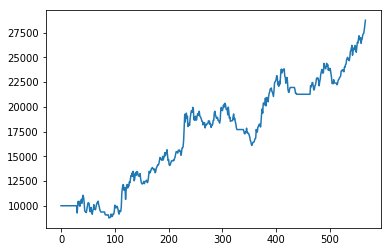

In [11]:
%matplotlib inline

weekly.returns.plot()

In [12]:
rollmax = weekly.returns.rolling(window=200,min_periods=1,center=False).max()
dailydd = weekly.returns / rollmax - 1

maxdd = dailydd.rolling(window=200,min_periods=1,center=False).min()

print(maxdd.min())

-0.209170943774
